In [51]:
# create a API key from Google cloud Console
# the Copy Paste youtube video link and keep the ID only.

api_key = 'ADD YOUR API KEY'
video_id=input("enter Video ID: ")

enter Video ID:  OY8rr5-SubM


In [63]:
# importing necessary libraries

import time
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import random

In [64]:
# fetching the basic details such as tittle, likes and dislikes

def get_video_details(video_id, api_key):
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    try:
        # Fetch video details including snippet and statistics
        video_response = youtube.videos().list(
            part='snippet,statistics',
            id=video_id
        ).execute()
        
        # Extract title from snippet
        title = video_response['items'][0]['snippet']['title']
        
        # Extract likes and dislikes from statistics
        stats = video_response['items'][0]['statistics']
        likes = int(stats.get('likeCount', 0))
        view_count = int(stats.get('viewCount', 0))
        
        # Fetch comment count separately as it's not always included in 'statistics'
        # It's part of the snippet
        
        comment_count = int(video_response['items'][0]['statistics']['commentCount'])
        
        return title, likes, view_count, comment_count
    except HttpError as e:
        print(f"An HTTP error occurred: {e}")
        return None, None, None, None

tittle, likes, view_count, comment_count = get_video_details(video_id, api_key)
print("Video Tittle : ", tittle)
print("Likes : ", likes)
print("Views Comment: ",view_count)
print("Comment Count : ",comment_count)

Video Tittle :  UK Election 2024: The headlines | BBC News
Likes :  313
Views Comment:  31548
Comment Count :  190


In [65]:
# Initialize the VADER sentiment intensity analyzer

sid = SentimentIntensityAnalyzer()

# function for collecting youtube comment data from the API

def get_video_comments(video_id, api_key, max_comments=3000):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    next_page_token = None
    fetched_comments = 0
    
    try:
        while fetched_comments < max_comments:
            response = youtube.commentThreads().list(
                part='snippet',
                videoId=video_id,
                maxResults=100,
                pageToken=next_page_token,
                order='relevance'
            ).execute()
            
            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                comments.append(comment)
                fetched_comments += 1
                if fetched_comments >= max_comments:
                    break
            
            next_page_token = response.get('nextPageToken')
            if not next_page_token:
                break

            time.sleep(1)  # Respect rate limits

    except HttpError as e:
        print(f"An HTTP error occurred: {e}")
    
    return comments

all_comments = get_video_comments(video_id, api_key, max_comments=3000)

# Randomly select 1000 comments from the fetched comments

random.seed(42)  # For reproducibility
if len(all_comments) > 1000:
    selected_comments = random.sample(all_comments, 1000)
else:
    selected_comments = all_comments

In [66]:
print(len(all_comments))
print(len(selected_comments))

57
57


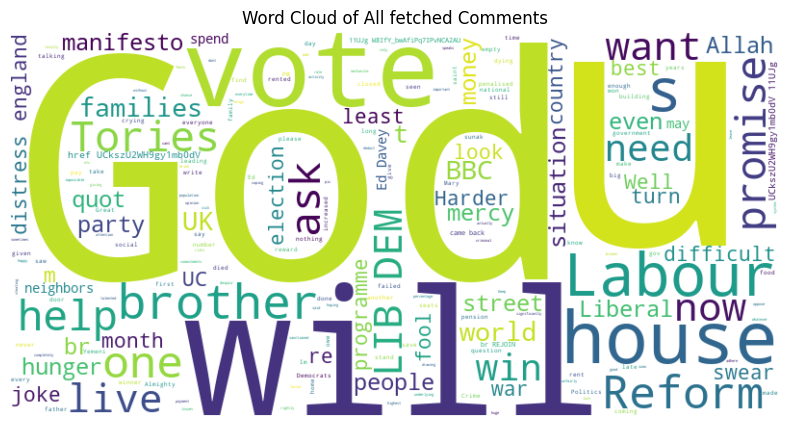

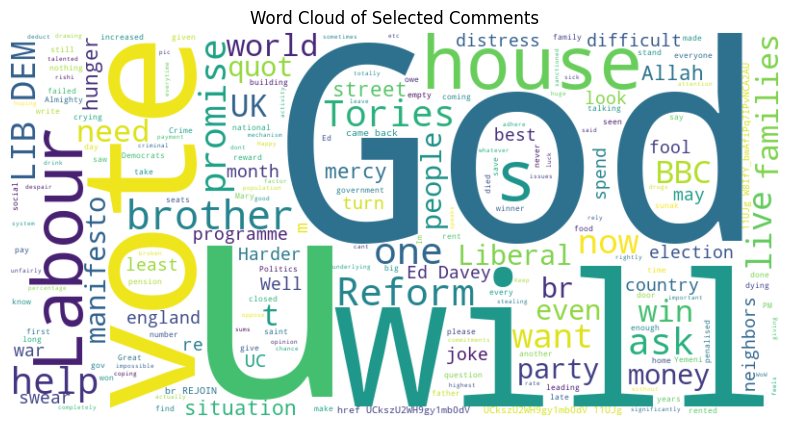

In [67]:
# visualization of the most frequent words used in the comments, giving a sense of the common topics and sentiments expressed
# 1) for all fetched comments
from wordcloud import WordCloud

all_comments_text = " ".join(all_comments)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All fetched Comments')
plt.show()

# 2) for comments selected for our analysis

all_comments_text = " ".join(selected_comments)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Selected Comments')
plt.show()

In [68]:
# function to calculate polarity score of individual comments and assigming their sentiment

def analyze_sentiment_vader(comment):
    scores = sid.polarity_scores(comment)
    if scores['compound'] > 0.05:
        return 'positive'
    elif scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# function to calculate Number of positive , negative, and neutral comments

def get_comments_sentiment_vader(comments):
    sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}

    for comment in comments:
        sentiment = analyze_sentiment_vader(comment)
        sentiments[sentiment] += 1

    return sentiments
    
comments_sentiment = get_comments_sentiment_vader(selected_comments)

In [69]:
# determining the overall sentiment of the video

def determine_video_sentiment_vader(comments_sentiment):
    total_comments = sum(comments_sentiment.values())
    if total_comments == 0:
        return 'neutral'  # Default to neutral if no comments
    
    # Calculate comment sentiment score
    comment_sentiment_score = (comments_sentiment['positive'] - comments_sentiment['negative']) / total_comments
    
    if comment_sentiment_score > 0.1:
        return 'positive'
    elif comment_sentiment_score < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Determine overall video sentiment
video_sentiment = determine_video_sentiment_vader(comments_sentiment)

In [70]:
# idetifying top positive and top negative comments

import html  # used to decode the comments if they contain any html tags with them which are often used to represent special characters

def print_top_positive_negative(selected_comments):
    score_list=[]
    for comment in selected_comments:
        score= sid.polarity_scores(comment)
        score_list.append(score['compound'])

    maxpos = score_list.index(max(score_list))
    minpos = score_list.index(min(score_list))

    print("Top Positive Comment: \n",html.unescape(selected_comments[maxpos] ))
    print("Top Negative Comment: \n",html.unescape(selected_comments[minpos] ))    
    
print_top_positive_negative(selected_comments)

Top Positive Comment: 
 England, you need God! You need to understand that PSYCHOTHERAPY is not only about mental health. Grab a rosary! Scolding with God is not sin. Doing your hobbies it's alright. Go to confession and holly communion! The Holy Spirit is leading the Church, not the scandals in it! We need saints! Everyone is called to sainthood! Ask saint Joseph husband of Mary, our Lady. The number one enemy to the freemasons is Our Blessed Virgin Mary! If you're doing this you'll have peace and joy!
Top Negative Comment: 
 Crime is at its highest rate an underlying factor is that families that rely on UC are sanctioned sometimes rightly and unfairly! Families are penalised which for them are huge sums of money. Families are in despair, turn to crime like stealing etc. some turn to drink or drugs has a coping mechanism. UC deduct big a percentage or completely leave families without payment while families still have to adhere to commitments! In my opinion this system has significant

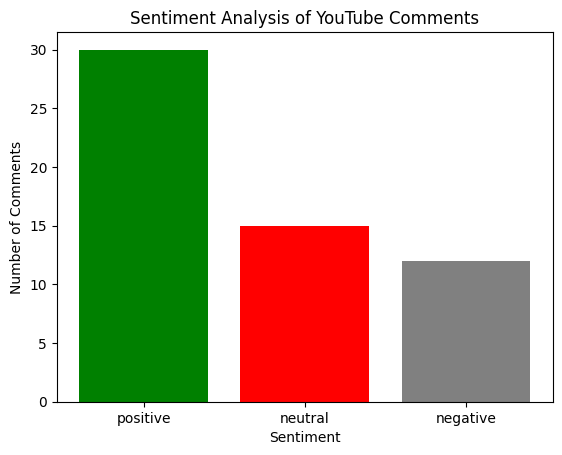

In [71]:
# visulization using bar chart, effective for comparing the counts or percentages of different sentiment categories (positive, negative, neutral).

import matplotlib.pyplot as plt
plt.bar(comments_sentiment.keys(),comments_sentiment.values(),color=['green', 'red', 'grey'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Analysis of YouTube Comments')
plt.show()

In [72]:
# Displaying total number of comments fetched and sentiment count

print(f"Number of comments fetched: {len(selected_comments)}")
print(f"Sentiment counts: {comments_sentiment} \n")

# calculate percentages of each sentiment

positive_percent=(comments_sentiment['positive']/len(selected_comments))*100
negative_percent=(comments_sentiment['negative']/len(selected_comments))*100
neutral_percent=(comments_sentiment['neutral']/len(selected_comments))*100

print("Percentage of Postive comments: ", round(positive_percent,2),"%")
print("Percentage of negative comments: ",round(negative_percent,2),"%")
print("Percentage of Neutral comments: ", round(neutral_percent,2),"%")
print("\nThe overall sentiment of the video is : ", video_sentiment)

Number of comments fetched: 57
Sentiment counts: {'positive': 30, 'neutral': 15, 'negative': 12} 

Percentage of Postive comments:  52.63 %
Percentage of negative comments:  21.05 %
Percentage of Neutral comments:  26.32 %

The overall sentiment of the video is :  positive
